<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [ ]:
# !pip install transformers==3.0.0
# !pip install transformers sentencepiece

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
df= pd.read_csv(
    "/content/drive/MyDrive/subject_final.csv")
df

,text,label
0,ยืนยันหมายเลขนัดส่งสินค้า xd,0
1,product complaint pure แจ้งคืนสินค้ารั่วซ...,0
2,fwd กิ่งใบ เอกสารเปิดหน้าบัญชี,0
3,ตอบกลับ สอบถามมูลหนี้ค้างชำระ บ อินเอตร์ เอ็ก...,0
4,value blog เมื่อจังหวะชีวิตไม่เท่ากัน ไม่เป็...,0
...,...,...
19460,this is the 2nd time we have tried 2 contact u...,1
19461,will ì_ b going to esplanade fr home?,0
19462,"pity, * was in mood for that. so...any other s...",0
19463,the guy did some bitching but i acted like i'd...,0


In [ ]:
df1=df.fillna('no subject')

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df1['text'], df1['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df1['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Tokenization

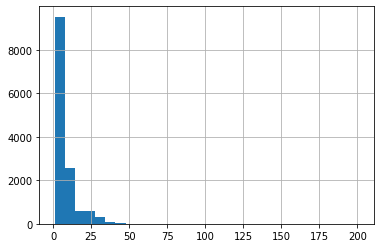

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 30

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.6318401  2.39623637]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float) 
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_save_name = 'saved_weights.pt'
        path = F"/content/drive/MyDrive/Colab Notebooks/{model_save_name}" 
        torch.save(model.state_dict(), path)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    426.
  Batch   100  of    426.
  Batch   150  of    426.
  Batch   200  of    426.
  Batch   250  of    426.
  Batch   300  of    426.
  Batch   350  of    426.
  Batch   400  of    426.

Evaluating...
  Batch    50  of     92.

Training Loss: 0.374
Validation Loss: 0.398

 Epoch 2 / 10
  Batch    50  of    426.
  Batch   100  of    426.
  Batch   150  of    426.
  Batch   200  of    426.
  Batch   250  of    426.
  Batch   300  of    426.
  Batch   350  of    426.
  Batch   400  of    426.

Evaluating...
  Batch    50  of     92.

Training Loss: 0.341
Validation Loss: 0.304

 Epoch 3 / 10
  Batch    50  of    426.
  Batch   100  of    426.
  Batch   150  of    426.
  Batch   200  of    426.
  Batch   250  of    426.
  Batch   300  of    426.
  Batch   350  of    426.
  Batch   400  of    426.

Evaluating...
  Batch    50  of     92.

Training Loss: 0.337
Validation Loss: 0.270

 Epoch 4 / 10
  Batch    50  of    426.
  Batch   100  of    426.
  Batc

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2311
           1       0.77      0.91      0.84       609

    accuracy                           0.93      2920
   macro avg       0.87      0.92      0.89      2920
weighted avg       0.93      0.93      0.93      2920



In [ ]:
preds

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,2166,145
1,66,543


## Test

In [ ]:
dt= pd.read_csv(
    "/content/drive/MyDrive/golden_label.csv")
dt

,text,Majority_label,LabelModel_label
0,ยืนยันหมายเลขนัดส่งสินค้า xd,0,0
1,not read re cpf ขออนุญาติใช้โลโก้ ลงสื่อโปรโ...,-1,0
2,product complaint pure แจ้งคืนสินค้ารั่วซ...,0,0
3,fwd กิ่งใบ เอกสารเปิดหน้าบัญชี,0,0
4,ตอบกลับ สอบถามมูลหนี้ค้างชำระ บ อินเอตร์ เอ็ก...,0,0
...,...,...,...
9676,acknowledge: นวลฉวี ทองใบ ขออนุมัติ ot วันที่ ...,0,0
9677,fwd: สมัครงานตำแหน่งเจ้าหน้าที่ธุรการขาย [from...,0,0
9678,acknowledge: วัง ปานทอง ขออนุมัติ ot วันที่ 04...,0,0
9679,chotika butprom ได้โพสต์รูปภาพ,0,0


In [ ]:
dt1=dt.loc[dt['Majority_label']==-1]
dt2=dt1[['text']]
dt2.reset_index(inplace=True)
dt3=dt2[['text']]
dt3

In [ ]:
dt3=dt2[['text']]
dt3

,text
0,not read re cpf ขออนุญาติใช้โลโก้ ลงสื่อโปรโ...
1,accepted task plan network and vps server ของ...
2,นำส่งโปรโมชั่น bro line add by karmarts
3,accepted ขอนัดประชุม migrate ระบบ ksc และ kes...
4,fwd เทพผดุงพรมะพร้าว ขอทำโปรโมชั่นวุ้นมะพร...
...,...
122,invitation: ส.ขอนแก่น x dgtl8 : mkt optimisati...
123,ฉลองวันสตรีสากล รับส่วนลดเพิ่มสูงถึง 50%
124,เรียนเชิญรับชมบทเรียนออนไลน์ในหัวข้อ microsoft...
125,สินค้า หมูดี หมูหยอง กรอบอร่อย พกพาสะดวก ขนาด ...


In [ ]:
# tokenize and encode sequences in the test set
tokens_test1 = tokenizer.batch_encode_plus(dt3.text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False)
# for test set
test_seq = torch.tensor(tokens_test1['input_ids'])
test_mask = torch.tensor(tokens_test1['attention_mask'])
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds

array([[-6.8090078e-03, -4.9929032e+00],
       [-8.4747636e-01, -5.5948192e-01],
       [-8.7798968e-02, -2.4762843e+00],
       [-1.3736362e-02, -4.2945647e+00],
       [-1.8072579e-02, -4.0223832e+00],
       [-2.0912462e-03, -6.1710253e+00],
       [-4.3420563e-03, -5.4415784e+00],
       [-2.1327091e-02, -3.8584218e+00],
       [-1.2547596e-02, -4.3844934e+00],
       [-7.7252328e-02, -2.5990551e+00],
       [-3.7239506e-03, -5.5948191e+00],
       [-2.3515388e-02, -3.7618361e+00],
       [-2.6521054e-03, -5.9337339e+00],
       [-3.3935621e-02, -3.4002082e+00],
       [-1.3971617e-02, -4.2777085e+00],
       [-4.7324793e-03, -5.3556833e+00],
       [-2.4005870e-04, -8.3348885e+00],
       [-1.6632546e-03, -6.3997936e+00],
       [-1.2830209e-02, -4.3623605e+00],
       [-1.0259981e-02, -4.5846329e+00],
       [-1.7568916e-02, -4.0503936e+00],
       [-7.0380867e-03, -4.9599438e+00],
       [-1.3793726e-03, -6.5867872e+00],
       [-1.5568528e-03, -6.4659009e+00],
       [-1.20233

In [ ]:
prediction = np.argmax(preds, axis = 1)

In [ ]:
prediction

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])